# 01 data_exploration
This notebook explores the raw dataset (financial_fraud_detection_dataset.csv) with: 
1. Setup & load data 
2. Time features (hour/day) 
3. Core stats & fraud rate 
4. Amount distributions 
5. Fraud vs non-fraud comparison 
6. Category breakdowns (type/channel/device/merchant) 
7. Temporal activity (by hour) 
8. Anomaly & velocity features 
9. Top accounts & sanity checks 
10. Sample & summary export

###  1.Setup & load data 

In [17]:
# 1. Setup & paths
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths
RAW_PATH = Path("../data/raw/financial_fraud_detection_dataset.csv")
PROC_DIR = Path("../data/processed")
FIG_DIR  = Path("../reports/figures")

PROC_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Helper: memory usage in MB
def memory_mb(df): 
    return df.memory_usage(deep=True).sum() / 1024**2

# 1.2. Load raw data
assert RAW_PATH.exists(), f"Raw CSV not found at {RAW_PATH}"
df_raw = pd.read_csv(RAW_PATH, low_memory=False)
print("Raw shape:", df_raw.shape, "| Memory (MB):", f"{memory_mb(df_raw):.1f}")
df_raw.head(3)


Raw shape: (5000000, 18) | Memory (MB): 3423.9


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631
2,T100002,2023-05-12T11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,False,NaN,NaN,-1.78,20,0.89,card,185.98.35.23,D4823498


In [18]:
# 1.3 Manually set column names we care about
SENDER_COL   = "sender_account"
RECEIVER_COL = "receiver_account"
AMOUNT_COL   = "amount"
FRAUD_COL    = "is_fraud"
TS_COL       = "timestamp"

TYPE_COL     = "transaction_type"
CHAN_COL     = "payment_channel"
DEVICE_COL   = "device_used"
MCHT_COL     = "merchant_category"

# Copy & rename for consistency
df_std = df_raw.copy()

rename_map = {
    SENDER_COL: "sender",
    RECEIVER_COL: "receiver",
    AMOUNT_COL: "amount",
    FRAUD_COL: "is_fraud",
    TS_COL: "timestamp",
    TYPE_COL: "type",
    CHAN_COL: "payment_channel",
    DEVICE_COL: "device_used",
    MCHT_COL: "merchant_category",
}

# Only rename columns that actually exist
rename_map = {k: v for k, v in rename_map.items() if k in df_std.columns}
df_std.rename(columns=rename_map, inplace=True)

# For later loops
CATEG_COLS = [c for c in ["type", "payment_channel", "device_used", "merchant_category"] if c in df_std.columns]

print("Standardized columns (first 12):", list(df_std.columns)[:12])
print("Category columns found:", CATEG_COLS)


Standardized columns (first 12): ['transaction_id', 'timestamp', 'sender', 'receiver', 'amount', 'type', 'merchant_category', 'location', 'device_used', 'is_fraud', 'fraud_type', 'time_since_last_transaction']
Category columns found: ['type', 'payment_channel', 'device_used', 'merchant_category']


### – Why standardize column names?

Different versions of the dataset sometimes use different names  
(e.g. `sender_account` vs. `nameOrig`).  
To make my code easier to run later, I rename the columns into a consistent set  
like `sender`, `receiver`, `amount`, `is_fraud`.  

This does not change the original data, it just gives me a cleaner copy (`df_std`)  
so I don’t have to worry about column name mismatches in the rest of the notebook.


### Step 2 – Time features (hour/day)

In [9]:
if "timestamp" in df_std.columns:
    ts = pd.to_datetime(df_std["timestamp"], errors="coerce")
    df_std["hour"] = ts.dt.hour
    df_std["day"] = ts.dt.day
elif "step" in df_std.columns:
    step_i = pd.to_numeric(df_std["step"], errors="coerce").fillna(0).astype(int)
    df_std["hour"] = (step_i % 24).astype(int)
    df_std["day"] = (step_i // 24).astype(int)
else:
    df_std["hour"] = np.nan
    df_std["day"] = np.nan
  
df_std[["hour_of_day","day_of_week"]].head()



,hour_of_day,day_of_week
0,9.0,1.0
1,1.0,4.0
2,11.0,4.0
3,6.0,1.0
4,8.0,6.0




We created two new columns from the raw timestamp:

- **hour_of_day (0–23)** → which hour in the day the transaction happened  
- **day_of_week (0=Monday … 6=Sunday)** → which weekday it belongs to  

Why is this useful?  
Fraud and scam activities are often not random in time.  
For example, fraudsters may prefer:
- late-night hours (when fewer staff monitor systems), or  
- weekends (when customers are less likely to check accounts).  

By extracting these simple features, we can later plot fraud vs non-fraud transactions by hour/day.  
This helps us spot temporal patterns and could be used as additional predictors in machine learning or ABM simulations.  


### Step 3 – Core stats & fraud rate

- Rows: 5M transactions, 22 columns  
- Amounts: median ≈ 139, mean ≈ 359, max ≈ 3520 → distribution is skewed  
- Fraud rate: ~3.6% (synthetic dataset, higher than real-world data)  

This gives us a quick big-picture view before deeper exploration.  


In [11]:
# Step 3 – Core stats & fraud rate

stats = {
    "n_rows": len(df_std),
    "n_cols": df_std.shape[1],
    "n_senders": df_std[SENDER_COL].nunique() if SENDER_COL in df_std else None,
    "n_receivers": df_std[RECEIVER_COL].nunique() if RECEIVER_COL in df_std else None,
    "amount_min": float(df_std[AMOUNT_COL].min()),
    "amount_median": float(df_std[AMOUNT_COL].median()),
    "amount_mean": float(df_std[AMOUNT_COL].mean()),
    "amount_max": float(df_std[AMOUNT_COL].max()),
}

# Fraud rate (if available)
if FRAUD_COL is not None:
    stats["fraud_rate"] = float(pd.to_numeric(df_std[FRAUD_COL], errors="coerce").mean())

pd.Series(stats)


n_rows           5.000000e+06
n_cols           2.200000e+01
n_senders                 NaN
n_receivers               NaN
amount_min       1.000000e-02
amount_median    1.386700e+02
amount_mean      3.589343e+02
amount_max       3.520570e+03
fraud_rate       3.591060e-02
dtype: float64

### Step 4 – Amount distributions

We plot the distribution of transaction amounts to see scale and skew.  
Fraud vs non-fraud is shown separately: this helps check if fraudsters prefer certain ranges (e.g. mid-range or larger transfers).  


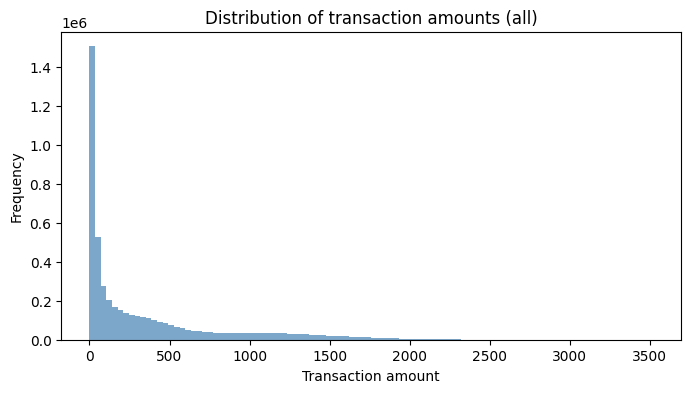

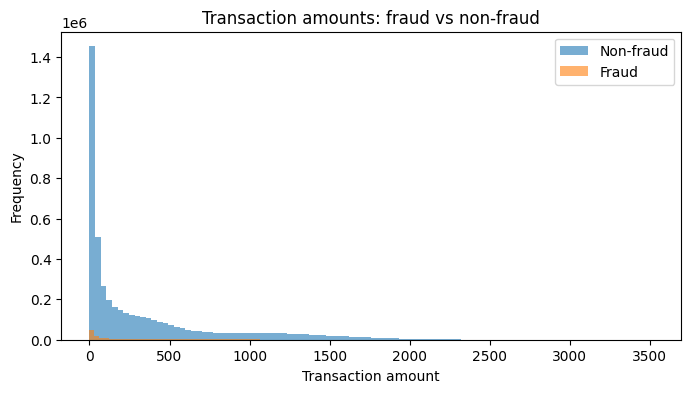

In [12]:
# Step 4 – Amount distributions

plt.figure(figsize=(8,4))
df_std[AMOUNT_COL].plot(kind="hist", bins=100, alpha=0.7, color="steelblue")
plt.xlabel("Transaction amount")
plt.ylabel("Frequency")
plt.title("Distribution of transaction amounts (all)")
plt.show()

# Fraud vs non-fraud comparison (if label available)
if FRAUD_COL is not None:
    plt.figure(figsize=(8,4))
    df_std[df_std[FRAUD_COL]==0][AMOUNT_COL].plot(kind="hist", bins=100, alpha=0.6, label="Non-fraud")
    df_std[df_std[FRAUD_COL]==1][AMOUNT_COL].plot(kind="hist", bins=100, alpha=0.6, label="Fraud")
    plt.xlabel("Transaction amount")
    plt.ylabel("Frequency")
    plt.title("Transaction amounts: fraud vs non-fraud")
    plt.legend()
    plt.show()




- Most transactions are very small, with a long tail up to a few thousand.  
- Fraudulent transactions (orange) are also concentrated at the **small-amount range**, instead of at very large amounts.  
- This suggests that attackers may use **many small transfers** (e.g., smurfing) to avoid detection, rather than a few obvious big ones.  
- Research value: amount alone is not enough to flag fraud, but observing this pattern motivates combining amount with **frequency, network connections, and timing** for better detection.  


Fraud amount stats:
 count    179553.000000
mean        358.528199
std         469.531257
min           0.010000
25%          26.480000
50%         137.880000
75%         501.720000
max        3128.140000
Name: amount, dtype: float64

Non-fraud amount stats:
 count    4.820447e+06
mean     3.589494e+02
std      4.699483e+02
min      1.000000e-02
25%      2.657000e+01
50%      1.387100e+02
75%      5.039600e+02
max      3.520570e+03
Name: amount, dtype: float64


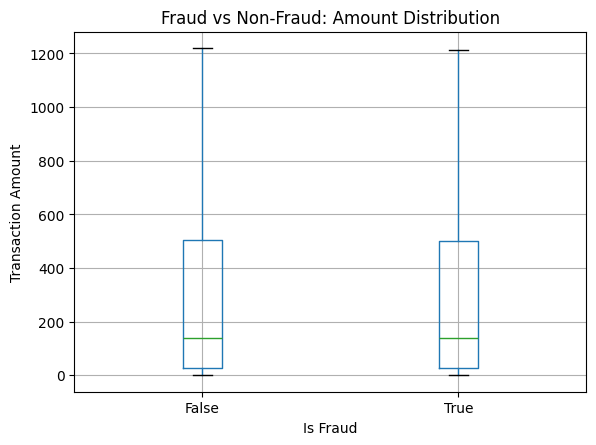

In [15]:
# 5. Fraud vs Non-Fraud comparison

if FRAUD_COL is not None:
    # simple describe
    fraud_stats = df_std[df_std[FRAUD_COL] == 1][AMOUNT_COL].describe()
    nonfraud_stats = df_std[df_std[FRAUD_COL] == 0][AMOUNT_COL].describe()
    print("Fraud amount stats:\n", fraud_stats)
    print("\nNon-fraud amount stats:\n", nonfraud_stats)

    # quick boxplot
    df_std.boxplot(column=AMOUNT_COL, by=FRAUD_COL, showfliers=False)
    plt.title("Fraud vs Non-Fraud: Amount Distribution")
    plt.suptitle("")
    plt.xlabel("Is Fraud")
    plt.ylabel("Transaction Amount")
    plt.show()


Transaction amounts alone do not provide strong separation between fraud and non-fraud. This suggests the need to incorporate additional features such as frequency, network structure, or device/channel information.

In [16]:
# 6. Category breakdowns (type, channel, device, merchant)

for col in [TYPE_COL, CHAN_COL, DEVICE_COL, MCHT_COL]:
    if col is not None and col in df_std:
        counts = df_std[col].value_counts(normalize=True)[:10]
        print(f"\nTop categories for {col}:\n", counts)
        counts.plot(kind="bar", figsize=(6,3))
        plt.title(f"Distribution of {col}")
        plt.show()


NameError: name 'TYPE_COL' is not defined